In [1]:
import pandas as pd
import datetime
from tqdm import tqdm
import re
import optuna
import operator
import numpy as np
import matplotlib.pyplot as plt
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
import requests
from datetime import timedelta
import pickle
from sklearn.linear_model import LinearRegression
import ta

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [2]:
def test_live(sample_duration):
    def vn30f():
        return requests.get("https://services.entrade.com.vn/chart-api/chart?from=1651727820&resolution=1&symbol=VN30F1M&to=9999999999").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    s = pd.read_csv('C:\python\VN30F1M.csv')
    s['Date'] = pd.to_datetime(s['Date']) + timedelta(hours =7)
    ohlc_dict = {                                                                                                             
        'Open': 'first',                                                                                                    
        'High': 'max',                                                                                                       
        'Low': 'min',                                                                                                        
        'Close': 'last',                                                                                                    
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    def process_data(input_df):
        vn30train = pd.DataFrame(input_df.resample(str(sample_duration)+'Min', on='Date', label='left').apply(ohlc_dict).dropna()).reset_index()#change s
        vn30train['Date'] = [str(i)[:16] for i in vn30train['Date']]
        return vn30train
    vn30f_base = pd.concat([process_data(vn30fm), process_data(s)]).sort_values('Date').drop_duplicates('Date').sort_values('Date')
    return vn30f_base

In [3]:
data = test_live(15)

In [3]:
data = test_live(15)

def create_ds(data):
    data.Date = pd.to_datetime(data.Date)
    dff = data[['Date', 'Open']]
    #dff['Date'] = pd.to_datetime(dff['Date'])
    dff['Date'].apply(lambda x:x.hour)
    df1 = dff.loc[(dff['Date'].apply(lambda x:x.minute)==00)&(dff['Date'].apply(lambda x:x.hour)==9)]
    df1.Date = [str(i)[:10] for i in df1.Date]

    df = data[['Date', 'Close']]
    #df['Date'] = pd.to_datetime(df['Date'])
    df['Date'].apply(lambda x:x.hour)
    df2 = df.loc[(df['Date'].apply(lambda x:x.minute)==15)&(df['Date'].apply(lambda x:x.hour)==9)]
    df2.Date = [str(i)[:10] for i in df2.Date]
    #df 9:30
    df3 = df.loc[(df['Date'].apply(lambda x:x.minute)==30)&(df['Date'].apply(lambda x:x.hour)==9)]
    df3.Date = [str(i)[:10] for i in df3.Date]
    #df 10:00
    df4 = df.loc[(df['Date'].apply(lambda x:x.minute)==00)&(df['Date'].apply(lambda x:x.hour)==10)]
    df4.Date = [str(i)[:10] for i in df4.Date]
    #ds
    ds = df1.merge(df2, how = 'inner', on = 'Date').merge(df3, how = 'inner', on = 'Date').merge(df4, how = 'inner', on = 'Date')
    ds.columns = ['Date', 'Open', '9:15', '9:30', '10:00']
    # find_low to merge to ds
    df10 = data[['Date', 'Low']]
    df10['Date'] = pd.to_datetime(df10['Date'])
    
    findlow = df10.loc[(df10['Date'].apply(lambda x:x.hour)>10)]
    findlow['Day'] = [str(i)[:10] for i in findlow.Date]

    data['Day'] = [str(i)[:10] for i in data.Date]
    low = findlow[['Day','Low']].groupby('Day').min()
    #high = data[['Day','High']].groupby('Day').max()
    #high['Date'] = high.index

    low['Date'] = low.index
    ds = ds.merge(low, how='left', on='Date')
    
    return ds
ds = create_ds(data)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7788\2067520469.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.Date = [str(i)[:10] for i in df1.Date]
C:\Users\Admin\AppData\Local\Temp\ipykernel_7788\2067520469.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.Date = [str(i)[:10] for i in df2.Date]
C:\Users\Admin\AppData\Local\Temp\ipykernel_7788\2067520469.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [4]:
def create_XY(ds):
    X = ds.drop(['Low', 'Date'], axis = 1)
    Y = ds['Low']
    X_train = X.loc[:900]
    X_test = X.loc[900:]
    Y_train = Y.loc[:900]
    Y_test = Y.loc[900:]
    return X_train, Y_train, X_test, Y_test
X_train, Y_train, X_test, Y_test = create_XY(ds)

Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

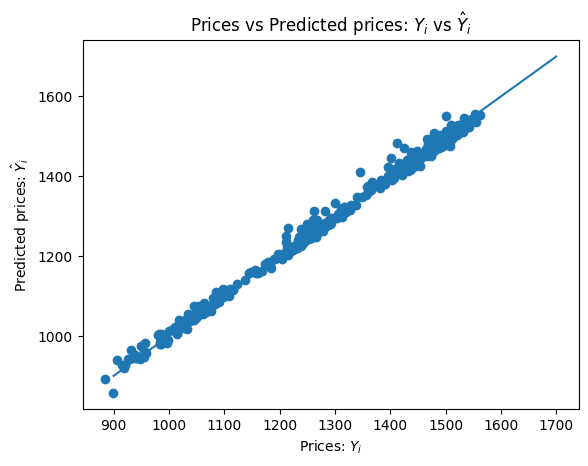

In [5]:
lm = pickle.load(open('finalized_model.sav', 'rb'))
Y_pred = lm.predict(X_test)
x = np.linspace(900, 1700, 100000)
plt.plot(x, x)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [6]:
def create_y_test(data, Y_test, Y_pred):
    Y_test = pd.DataFrame(Y_test)
    Y_test['pred'] = Y_pred

    ope = data[['Date', 'Open']]
    ope['Date'] = pd.to_datetime(ope['Date'])
    ope['Date'].apply(lambda x:x.hour)
    op = ope.loc[(ope['Date'].apply(lambda x:x.minute)==15)&(ope['Date'].apply(lambda x:x.hour)==10)]
    op.Date = [str(i)[:10] for i in op.Date]

    Y_test['Date'] = ds.Date.iloc[900:]
    Y_test = Y_test.merge(op, how='inner', on='Date')
    Y_test.drop('Date', axis = 1)
    Y_test['dev'] = Y_test.pred - Y_test.Open
    Y_test['Date'] = [str(i)+ ' 10:15' for i in Y_test.Date]
    Y_test.Date = [str(i) for i in Y_test.Date]
    Y_test['accu'] = (Y_test.Low - Y_test.pred)
    Y_test.Date = pd.to_datetime(Y_test.Date)
    return Y_test
Y_test = create_y_test(data, Y_test, Y_pred)

C:\Users\Admin\AppData\Local\Temp\ipykernel_7788\3565763201.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ope['Date'] = pd.to_datetime(ope['Date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_7788\3565763201.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op.Date = [str(i)[:10] for i in op.Date]


In [7]:
def create_signal(Y_test, data):
    sig = Y_test[['Date', 'dev']]
    signal = pd.DataFrame()
    signal = data.merge(sig, how='left', on='Date')
    signal = signal.fillna(110)

    ok = Y_test[['Date', 'pred']]
    signal = signal.merge(ok, how='left', on='Date')
    signal = signal.fillna(method='pad')
    return signal
signal = create_signal(Y_test, data)

In [8]:
signal

Date    Open    High     Low   Close   Volume  \
0     2017-08-10 09:15:00   757.9   757.9   755.5   755.5     26.0   
1     2017-08-10 09:30:00   755.1   755.1   753.8   753.8     21.0   
2     2017-08-10 09:45:00   753.6   753.6   752.3   752.3     13.0   
3     2017-08-10 10:00:00   752.0   752.0   750.4   750.4     17.0   
4     2017-08-10 10:15:00   750.0   750.0   748.2   748.2     20.0   
...                   ...     ...     ...     ...     ...      ...   
26010 2023-02-08 11:00:00  1072.3  1073.1  1069.3  1069.8  17799.0   
26011 2023-02-08 11:15:00  1069.8  1070.2  1067.8  1069.5  14702.0   
26012 2023-02-08 11:30:00  1069.5  1069.5  1069.3  1069.5     37.0   
26013 2023-02-08 13:00:00  1069.3  1071.3  1065.9  1067.4  19673.0   
26014 2023-02-08 13:15:00  1067.5  1068.9  1065.9  1068.9  11946.0   

              Day    dev         pred  
0      2017-08-10  110.0          NaN  
1      2017-08-10  110.0          NaN  
2      2017-08-10  110.0          NaN  
3      2017-08-10  110.0          NaN  
4      2017-08-10  110.0          NaN  
...           ...    ...          ...  
26010  2023-02-08  110.0  1065.930374  
26011  2023-02-08  110.0  1065.930374  
26012  2023-02-08  110.0  1065.930374  
26013  2023-02-08  110.0  1065.930374  
26014  2023-02-08  110.0  1065.930374  

[26015 rows x 9 columns]

In [9]:
# buys = 0
# buyl = 0
# profit = []
# position = []
# profitl = []
# date = []
# time = []
# day = 0
# for i in tqdm(range(len(signal))):
#     if buys ==0:
#         if (signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-5] < -3 and signal.Open.iloc[i] - signal.Close.iloc[i-4] <= -1.5):# or (signal.dev.iloc[i] < -7 and signal.Open.iloc[i] - signal.Close.iloc[i-5] < 0):
#             buys = signal.Open.iloc[i]
#             position.append(-1)
#             time.append(signal.Date.iloc[i])
#             if buyl != 0:
#                 profit.append(signal.Open.iloc[i] - buyl)
#                 #time.append(signal.Date.iloc[i])
#                 date.append(signal.Date.iloc[i])
#                 buyl = 0
#             #date.append(signal.Date.iloc[i])
#     if buys != 0:
#         if ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==30):
#             long = buys - signal.Close.iloc[i]
#         if ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==45):
#             profit.append(buys - signal.Open.iloc[i])
#             date.append(signal.Date.iloc[i])
#             buys = 0
#             if long > 4:
#                 buyl = signal.Open.iloc[i]
#                 day = signal.Date.iloc[i].day
#                 position.append(1)
#                 time.append(signal.Date.iloc[i])
#             else:
#                 position.append(0)
#                 time.append(signal.Date.iloc[i])
#     if buyl != 0:
#         if ((signal.Date.iloc[i].day - day > 4 or signal.Date.iloc[i].day - day < -27) and signal.Open.iloc[i] - buyl < -10) or (signal.dev.iloc[i] < -5 and signal.Open.iloc[i] - signal.Close.iloc[i-5] < 0) or (signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-5] < -3 and signal.Open.iloc[i] - signal.Close.iloc[i-4] <= -2.5):
#             profit.append(signal.Open.iloc[i] - buyl)
#             position.append(-1)
#             time.append(signal.Date.iloc[i])
#             date.append(signal.Date.iloc[i])
#             buyl = 0
#             buys = signal.Open.iloc[i]
# pnl_report = pd.DataFrame()
# pnl_report['Date'] = date
# pnl_report['gain'] = profit
# pnl_report = pnl_report.set_index('Date').resample("D").sum().dropna().reset_index()
# pnl_report['index'] = range(len(pnl_report))
# pnl_report.set_index('index', inplace=True)
# pnl_report = pnl_report[pnl_report.index > 596]
# pnl_report = pnl_report.loc[pnl_report['Date'].apply(lambda x:x.weekday()) < 5]
# pnl_report['total_gain'] = pnl_report.gain.cumsum()
# pd.Series(profit).cumsum().plot(figsize=(12,5))

100%|██████████| 26015/26015 [00:00<00:00, 45063.41it/s]


<AxesSubplot:>

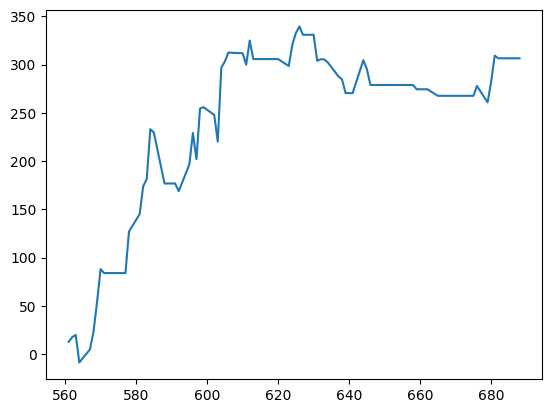

In [10]:
buys = 0
buyl = 0
profit = []
position = []
profitl = []
date = []
time = []
day = 0
for i in tqdm(range(len(signal))):
    pos = 0
    if buys ==0 and buyl == 0:
        if (signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-5] < -3 and signal.Open.iloc[i] - signal.Close.iloc[i-4] < -1.5):# or (signal.dev.iloc[i] < -7 and signal.Open.iloc[i] - signal.Close.iloc[i-5] < 0):
            buys = signal.Open.iloc[i]
            position.append(-1)
            time.append(signal.Date.iloc[i])
            #date.append(signal.Date.iloc[i])
    if buys != 0 and buyl == 0:
        if ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==30):
            long = buys - signal.Close.iloc[i]
        if ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==45):
            profit.append(buys - signal.Open.iloc[i])
            date.append(signal.Date.iloc[i])
            buys = 0
            if long > 1:
                buyl = signal.Open.iloc[i]
                day = signal.Date.iloc[i].day
                position.append(1)
                time.append(signal.Date.iloc[i])
            else:
                position.append(0)
                time.append(signal.Date.iloc[i])
    if buyl != 0 and buys == 0 and ((signal.Date.iloc[i]).hour == 10 and (signal.Date.iloc[i]).minute==15):
        if ((signal.Date.iloc[i].day - day > 4 or signal.Date.iloc[i].day - day < -27) and signal.Open.iloc[i] - buyl < -10) or (signal.dev.iloc[i] < -5 and signal.Open.iloc[i] - signal.Close.iloc[i-5] < -1.5) or (signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-5] < -3 and signal.Open.iloc[i] - signal.Close.iloc[i-4] < -2.5):
            pos = 1
            profit.append(signal.Open.iloc[i] - buyl)
            date.append(signal.Date.iloc[i])
            position.append(-1)
            time.append(signal.Date.iloc[i])
            buyl = 0
            buys = signal.Open.iloc[i]
# pnl_report = pd.DataFrame()
# pnl_report['Date'] = date
# pnl_report['gain'] = profit
# pnl_report = pnl_report.set_index('Date').resample("D").sum().dropna().reset_index()
# pnl_report['index'] = range(len(pnl_report))
# pnl_report.set_index('index', inplace=True)
# #pnl_report = pnl_report[pnl_report.index > 590]
# pnl_report = pnl_report.loc[pnl_report['Date'].apply(lambda x:x.weekday()) < 5]
# pnl_report['total_gain'] = pnl_report.gain.cumsum()
# pnl_report.total_gain.plot()

df = pd.DataFrame()
df['Date'] = time
df['profit'] = position
short = data.merge(df, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)
pnl = pd.DataFrame()
pnl['daily_gain'] = ((short['Open'].shift(-1) - short['Open'])*short['profit']).resample('D').sum().dropna()
pnl = pnl.reset_index()
pnl = pnl.loc[pnl['Date'].apply(lambda x:x.weekday()) < 5]
pnl = pnl.loc[pnl.Date > pd.Timestamp('2022-10-3')]
pnl['total_gain'] = pnl.daily_gain.cumsum().dropna()
pnl.total_gain.plot()

In [11]:
pnl

Date  daily_gain  total_gain
561 2022-10-04        12.6        12.6
562 2022-10-05         4.9        17.5
563 2022-10-06         2.3        19.8
564 2022-10-07       -28.6        -8.8
567 2022-10-10        13.6         4.8
..         ...         ...         ...
682 2023-02-02        -2.8       306.6
683 2023-02-03         0.0       306.6
686 2023-02-06         0.0       306.6
687 2023-02-07         0.0       306.6
688 2023-02-08         0.0       306.6

[92 rows x 3 columns]

In [12]:
buys = 0
buyl = 0
profit = []
position = []
profitl = []
date = []
time = []
day = 0

for i in tqdm(range(len(signal))):
    #S = 0
    if buys ==0 and buyl == 0:
        if (signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-5] < -3 and signal.Open.iloc[i] - signal.Close.iloc[i-4] <= -1.5):# or (signal.dev.iloc[i] < -7 and signal.Open.iloc[i] - signal.Close.iloc[i-5] < 0):
            buys = signal.Open.iloc[i]
            position.append(-1)
            time.append(signal.Date.iloc[i])
            #date.append(signal.Date.iloc[i])
            S = 1
    if buys != 0:
        if ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==30):
            long = buys - signal.Close.iloc[i]
        #if ((signal.Date.iloc[i]).hour == 14 and (signal.Date.iloc[i]).minute==30):
            profit.append(buys - signal.Open.iloc[i])
            date.append(signal.Date.iloc[i])
            buys = 0
            # if long > 1:
            buyl = signal.Open.iloc[i]
            day = signal.Date.iloc[i].day
            position.append(1)
            time.append(signal.Date.iloc[i])
            # else:
            #     position.append(0)
            #     time.append(signal.Date.iloc[i])
    if buyl != 0 and buys == 0 and ((signal.Date.iloc[i]).hour == 10 and (signal.Date.iloc[i]).minute==15):
        if ((signal.Date.iloc[i].day - day > 4 or signal.Date.iloc[i].day - day < -27) and signal.Open.iloc[i] - buyl < -10) or (signal.dev.iloc[i] < -5 and signal.Open.iloc[i] - signal.Close.iloc[i-5] < 0) or (signal.dev.iloc[i] < -5 and -16 < signal.Open.iloc[i] - signal.Close.iloc[i-5] < -3 and signal.Open.iloc[i] - signal.Close.iloc[i-4] <= -2.5):
            profit.append(signal.Open.iloc[i] - buyl)
            position.append(-1)
            time.append(signal.Date.iloc[i])
            date.append(signal.Date.iloc[i])
            buyl = 0
            buys = signal.Open.iloc[i]
df = pd.DataFrame()
df['Date'] = time
df['profit'] = position
short = data.merge(df, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)
pnl = pd.DataFrame()
pnl['daily_gain'] = ((short['Open'].shift(-1) - short['Open'])*short['profit']).resample('D').sum().dropna()
pnl = pnl.reset_index()
pnl = pnl.loc[pnl['Date'].apply(lambda x:x.weekday()) < 5]
#pnl = pnl.loc[pnl.Date > pd.Timestamp('2022-11-3')]
pnl['total_gain'] = pnl.daily_gain.cumsum().dropna()
#pd.Series(profit).cumsum().plot(figsize=(12,5))

100%|██████████| 26015/26015 [00:00<00:00, 45427.45it/s]


<AxesSubplot:xlabel='Date'>

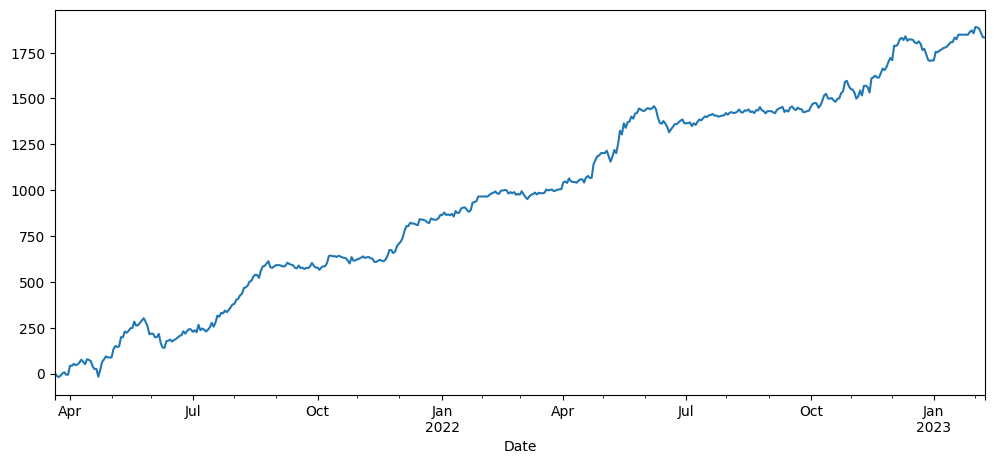

In [13]:
df10 = pnl.set_index('Date')
df10.total_gain.plot(figsize=(12,5))

In [14]:
pnl

Date  daily_gain  total_gain
0   2021-03-22         4.6         4.6
1   2021-03-23       -17.5       -12.9
2   2021-03-24        -6.2       -19.1
3   2021-03-25         7.3       -11.8
4   2021-03-26        12.5         0.7
..         ...         ...         ...
682 2023-02-02        -2.2      1886.9
683 2023-02-03        -6.4      1880.5
686 2023-02-06       -25.3      1855.2
687 2023-02-07       -21.8      1833.4
688 2023-02-08        -1.8      1831.6

[493 rows x 3 columns]

<AxesSubplot:xlabel='Date'>

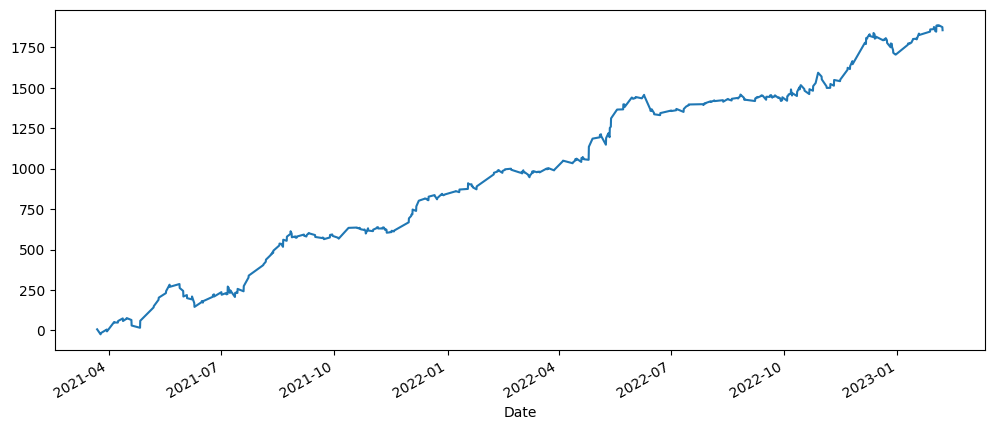

In [15]:
df = pd.DataFrame()
df['Date'] = date
df['profit'] = profit
df.set_index('Date', inplace=True)
df.profit.cumsum().plot(figsize=(12,5))

In [16]:
df = pd.DataFrame()
df['Date'] = time
df['profit'] = position

# df.set_index('Date', inplace=True)
df
# df.profit.cumsum().plot(figsize=(12,5))

Date  profit
0   2021-03-22 10:15:00      -1
1   2021-03-22 14:30:00       1
2   2021-03-25 10:15:00      -1
3   2021-03-25 14:30:00       1
4   2021-03-30 10:15:00      -1
..                  ...     ...
435 2023-02-02 14:30:00       1
436 2023-02-03 10:15:00      -1
437 2023-02-03 14:30:00       1
438 2023-02-06 10:15:00      -1
439 2023-02-06 14:30:00       1

[440 rows x 2 columns]

In [18]:
# df = pd.DataFrame()
# df['Date'] = time
# df['profit'] = position
# short = data.merge(df, how = 'left', on='Date')
# short = short.fillna(method='pad').dropna()
# short.set_index('Date', inplace=True)
# pnl = pd.DataFrame()
# pnl['daily_gain'] = ((short['Open'].shift(-1) - short['Open'])*short['profit']).resample('D').sum().dropna()
# pnl = pnl.reset_index()
# pnl = pnl.loc[pnl['Date'].apply(lambda x:x.weekday()) < 5]
# pnl = pnl.loc[pnl.Date > pd.Timestamp('2022-11-3')]
# pnl['total_gain'] = pnl.daily_gain.cumsum().dropna()
# pnl.total_gain.plot()

In [17]:
short = data.merge(df, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)


In [18]:
short['signal_long'] = np.where(short.profit == 1, 1, 0)
short['signal_short'] = np.where(short.profit == -1, 1, 0)
def margin(test):    
    test['inLong'] = test.signal_long.diff()[test.signal_long.diff() > 0]
    test['inShort'] = test.signal_short.diff()[test.signal_short.diff() > 0]
    test['outLong'] = -test.signal_long.diff()[test.signal_long.diff() < 0]
    test['outShort'] = -test.signal_short.diff()[test.signal_short.diff() < 0]
    test.loc[test.index[0], 'inLong'] = test.signal_long.iloc[0]
    test.loc[test.index[0], 'inShort'] = test.signal_short.iloc[0]
    test.fillna(0, inplace=True)
    return 1257.55/(test.inLong * test.Open + test.inShort * test.Open + test.outLong * test.Open + test.outShort * test.Open).sum()*10000
margin(short)

10.770397529630262

In [19]:
pnl = pd.DataFrame()
pnl['daily_gain'] = ((short['Open'].shift(-1) - short['Open'])*short['profit']).resample('D').sum().dropna()
pnl['total_gain'] = pnl.daily_gain.cumsum().dropna()
pnl = pnl.reset_index()
pnl = pnl.loc[pnl['Date'].apply(lambda x:x.weekday()) < 5]

In [20]:
def maximum_drawdown_future(backtest):
    max_drawdown = 0
    for i in tqdm(range(1, len(backtest))):
        drawdown = (backtest.rolling(i).max().iloc[i] - backtest.iloc[i])
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown
def sharpe(pnl):
    r = pnl.diff()
    return (r.mean()/r.std() * np.sqrt(252))
print('max drawdown: ',maximum_drawdown_future((((short['Open'].shift(-1) - short['Open'])*short['profit']).cumsum()).resample('D').last().dropna()))
print(sharpe((((short['Open'].shift(-1) - short['Open'])*short['profit']).cumsum()).resample('D').last().dropna()))

100%|██████████| 470/470 [00:00<00:00, 4088.65it/s]

max drawdown:  161.5
3.48694571845598


In [21]:
print('max drawdown: ', maximum_drawdown_future(pnl['total_gain']))
print('sharpe: ', sharpe(pnl['total_gain']))

100%|██████████| 492/492 [00:00<00:00, 4355.95it/s]

max drawdown:  161.5
sharpe:  3.4045779571175605


In [22]:
print('sum: ', pd.Series(profit).sum())
print('len: ', len(profit))
#xac suat thang
d=0
a=0
for i in profit:
    if i > 0:
        d += 1
    if i < 0:
        a += 1
print('win rate: ', d/(d+a))
print('profit:')
s=0
for i in range(1,20):
    print(profit[-i])
    s = s+profit[-i]
print(s)

sum:  1855.9000000000024
len:  439
win rate:  0.5606407322654462
profit:
-19.200000000000045
-11.200000000000045
4.5
-2.1000000000001364
-2.800000000000182
2.599999999999909
37.0
-4.0
-18.59999999999991
-6.0
13.199999999999818
1.599999999999909
13.700000000000045
20.90000000000009
-8.899999999999864
35.90000000000009
-4.599999999999909
2.400000000000091
5.5
59.899999999999864


In [23]:
pd.Series(profit).max()

131.19999999999993